<a href="https://colab.research.google.com/github/qortjdbs/ISEF_SullivanVision/blob/main/FER_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/ISEF/dataset2.zip

In [ ]:
import os

from platform import python_version
import warnings
import time
import datetime as dtw
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input, decode_predictions
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import regularizers
from keras.initializers import glorot_uniform
from keras.models import Model


import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

# Setting

## Parameters

In [ ]:
epochs = 100
batch_size = 48
testsplit = .2
targetx = 96
targety = 96
learning_rate = 0.0001
classes = 7
seed = 23

datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Preprocessing

## Setting Directories

In [ ]:
from keras.preprocessing import image
import numpy as np

def augment_and_save_images(data_dir, save_dir, datagen, num_augmentations=5):
    for subdir, dirs, files in os.walk(data_dir):
        for file in files:
            img_path = os.path.join(subdir, file)
            img = image.load_img(img_path, target_size=(targetx, targety))  # Ensure dimensions match your requirements
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)

            # Define a saving directory for this image's augmentations
            save_prefix = os.path.join(save_dir, os.path.basename(subdir))
            if not os.path.exists(save_prefix):
                os.makedirs(save_prefix)

            # Create and save augmented images
            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=save_prefix, save_prefix='aug', save_format='jpeg'):
                i += 1
                if i >= num_augmentations:
                    break  # This creates 'num_augmentations' new images per original image

data_dir = '/content/dataset'  # The directory of your original dataset
save_dir = '/content/augmented_dataset'  # Where to save the augmented images
num_augmentations = 5  # Number of augmented images to create per original image

augment_and_save_images(data_dir, save_dir, datagen, num_augmentations)


## Data Augumentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    vertical_flip=True,  # Added vertical flip
    rotation_range=30,  # Rotate images within this range
    width_shift_range=0.2,  # Shift images horizontally
    height_shift_range=0.2,  # Shift images vertically
    shear_range=0.2,  # Shearing
    zoom_range=0.2,  # Zooming
    fill_mode='nearest',
    validation_split=testsplit,
    preprocessing_function=preprocess_input,
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    save_dir,
    target_size=(targetx, targety),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed,
    subset="training"
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    save_dir,
    target_size=(targetx, targety),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=seed,
    subset="validation",
)

Found 3771 images belonging to 7 classes.
Found 939 images belonging to 7 classes.


# Training

In [ ]:
checkpoint = ModelCheckpoint('FER.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)

## InceptionV3

In [ ]:
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_initializer=glorot_uniform(seed), kernel_regularizer=regularizers.L2(0.001), activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_initializer=glorot_uniform(seed), kernel_regularizer=regularizers.L2(0.001), activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed), kernel_regularizer=regularizers.L2(0.001), activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

## DenseNet

In [ ]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten() (x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(512, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(256, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

29084464/29084464 [==============================] - 2s 0us/step


## ResNet50

In [ ]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten() (x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(512, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(256, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])

## Xception

In [ ]:
# Xception

base_model = Xception(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu', kernel_initializer=glorot_uniform(seed), kernel_regularizer=regularizers.L2(0.001), activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu', kernel_initializer=glorot_uniform(seed), kernel_regularizer=regularizers.L2(0.001), activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed), kernel_regularizer=regularizers.L2(0.001), activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])


83683744/83683744 [==============================] - 4s 0us/step


## Xception-AdCorre

In [ ]:
# Xception + Ad-Corre

class AdCorreLoss(tf.keras.losses.Loss):
    def __init__(self, num_classes, lambda_param=0.5, **kwargs):
        super(AdCorreLoss, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.lambda_param = lambda_param

    def call(self, y_true, y_pred):
        # Standard categorical cross-entropy loss
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

        # Calculate the Ad-Corre components
        fd_loss = self.feature_discriminator_loss(y_true, y_pred)
        md_loss = self.mean_discriminator_loss(y_true, y_pred)
        ed_loss = self.embedding_discriminator_loss(y_pred)

        # Total Ad-Corre loss
        ad_corre_loss = ce_loss + self.lambda_param * (fd_loss + md_loss + ed_loss)
        return ad_corre_loss

    def feature_discriminator_loss(self, y_true, y_pred):
        # Compute correlation matrix for the feature discriminator
        corr_matrix = self.compute_correlation_matrix(y_pred)

        # Create npSign matrix based on true labels
        np_sign = tf.sign(tf.tensordot(y_true, tf.transpose(y_true), axes=1))

        # Compute Feature Discriminator Loss
        fd_loss = tf.reduce_mean(tf.abs(np_sign - corr_matrix))
        return fd_loss

    def mean_discriminator_loss(self, y_true, y_pred):
        # Compute mean of embedded feature vectors for each class
        mean_vectors = tf.tensordot(y_true, y_pred, axes=1) / tf.reduce_sum(y_true, axis=0, keepdims=True)

        # Compute correlation matrix for the mean vectors
        corr_matrix = self.compute_correlation_matrix(mean_vectors)

        # Compute Mean Discriminator Loss
        md_loss = tf.reduce_sum(tf.abs(1 + corr_matrix)) / self.num_classes
        return md_loss

    def embedding_discriminator_loss(self, y_pred):
        # Compute correlation matrix for embedded feature vectors
        corr_matrix = self.compute_correlation_matrix(y_pred)

        # Compute Embedding Discriminator Loss
        ed_loss = tf.reduce_sum(tf.abs(1 + corr_matrix)) / y_pred.shape[1]
        return ed_loss

    def compute_correlation_matrix(self, vectors):
        # Subtract mean from vectors
        mean = tf.reduce_mean(vectors, axis=0, keepdims=True)
        vectors_centered = vectors - mean

        # Compute covariance
        covariance = tf.matmul(vectors_centered, vectors_centered, transpose_a=True)

        # Compute variance
        variance = tf.linalg.diag_part(covariance)

        # Compute correlation matrix
        correlation_matrix = covariance / (tf.sqrt(variance[:, None]) * tf.sqrt(variance[None, :]) + 1e-8)
        return correlation_matrix

# Model architecture
def build_model(input_shape, num_classes, learning_rate, seed):
    base_model = Xception(include_top=False, weights='imagenet', input_shape=input_shape)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu', kernel_initializer=glorot_uniform(seed),
              kernel_regularizer=regularizers.L2(0.001),
              activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_initializer=glorot_uniform(seed),
              kernel_regularizer=regularizers.L2(0.001),
              activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed),
              kernel_regularizer=regularizers.L2(0.001),
              activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax',
                        kernel_initializer='random_uniform', bias_initializer='zeros')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile model with Ad-Corre Loss
    ad_corre_loss = AdCorreLoss(num_classes=num_classes)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=ad_corre_loss, metrics=["accuracy"])

    # Make all layers trainable
    for layer in model.layers:
        layer.trainable = True

    return model

# Usage example
input_shape = (224, 224, 3)  # Define your input shape
num_classes = 7  # Define the number of classes
learning_rate = 0.001
seed = 42

model_Xception_AdCorre = build_model(input_shape, num_classes, learning_rate, seed)

# Model summary
model_Xception_AdCorre.summary()


# Results

## Training Process

In [ ]:
%%time


model_history = model_Xception_AdCorre.fit_generator(generator=train_generator,
                                steps_per_epoch=len(train_generator),
                                validation_data=val_generator,
                                validation_steps=len(val_generator),
                                epochs=epochs,
                                callbacks=[checkpoint])


Epoch 1/100
79/79 [==============================] - ETA: 0s - loss: 3.0232 - accuracy: 0.3288
Epoch 1: val_accuracy improved from -inf to 0.17891, saving model to model_isef2.h5
79/79 [==============================] - 48s 222ms/step - loss: 3.0232 - accuracy: 0.3288 - val_loss: 3.1229 - val_accuracy: 0.1789
Epoch 2/100
79/79 [==============================] - ETA: 0s - loss: 2.5009 - accuracy: 0.4495
Epoch 2: val_accuracy did not improve from 0.17891
79/79 [==============================] - 15s 195ms/step - loss: 2.5009 - accuracy: 0.4495 - val_loss: 2.9767 - val_accuracy: 0.1374
Epoch 3/100
79/79 [==============================] - ETA: 0s - loss: 2.0213 - accuracy: 0.6049
Epoch 3: val_accuracy did not improve from 0.17891
79/79 [==============================] - 15s 194ms/step - loss: 2.0213 - accuracy: 0.6049 - val_loss: 3.1166 - val_accuracy: 0.1789
Epoch 4/100
79/79 [==============================] - ETA: 0s - loss: 1.5645 - accuracy: 0.7160
Epoch 4: val_accuracy did not improve 

## Visualization

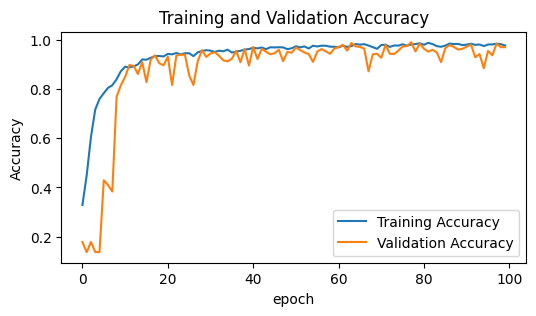

In [ ]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()